# Required module

In [19]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import cohen_kappa_score, roc_auc_score, balanced_accuracy_score, RocCurveDisplay
from sklearn.model_selection import ShuffleSplit, cross_validate, RepeatedKFold
from sklearn.model_selection import learning_curve, validation_curve
import matplotlib.pyplot as plt
import shap

# Standardization

In [2]:
def stand(tr, te):
    mean = tr.mean()
    stdev = tr.std()
    n_tr = (tr-mean)/stdev
    n_te = (te-mean)/stdev
    return n_tr, n_te

# Data set

In [3]:
train = pd.read_excel("Train(cl).xlsx", index_col=0)
test = pd.read_excel("Test(cl).xlsx", index_col=0)
x_tr = train.iloc[:,:-1]
x_te = test.iloc[:,:-1]
y_tr = train.iloc[:,-1]
y_te = test.iloc[:,-1]
x_tr, x_te = stand(x_tr, x_te)
print(x_tr.shape, "\n", x_te.shape, "\n", y_tr.shape, "\n", y_te.shape)

(932, 10) 
 (309, 10) 
 (932,) 
 (309,)


# Optimization

In [4]:
classifier = SVC()
parameters = { 'C':[0.1,1,10,100,1000], 
              'kernel':['rbf', 'poly', 'linear'], 
              'gamma': ["auto","scale"]
               }
GS = GridSearchCV(estimator = classifier,
                  param_grid = parameters,
                  scoring ='accuracy',
                  cv = 5,
                  verbose = 4)
GS.fit(x_tr,y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.626 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.583 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.704 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.661 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.672 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.561 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.599 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.575 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.591 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.527 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.610 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['rbf', 'poly', 'linear']},
             scoring='accuracy', verbose=4)

In [5]:
estimator_gs = GS.best_params_
print(estimator_gs)

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


# Model development

In [7]:
cls=SVC(C=1.0, gamma="scale", kernel='rbf').fit(x_tr, y_tr)
ytr_pred = cls.predict(x_tr)
yte_pred = cls.predict(x_te)

# Metrics

In [8]:
def metrics(obs, pred):
    acc=accuracy_score(obs, pred)
    pre = precision_score(obs, pred)
    f1s = f1_score(obs, pred)
    mcc = matthews_corrcoef(obs, pred)
    cok = cohen_kappa_score(obs, pred)
    roc = roc_auc_score(obs, pred)
    rec= recall_score(obs, pred)
    ba= balanced_accuracy_score(obs, pred)
    spec= (2*ba)-rec
    print("Accuracy: %.3f" %acc)
    print("Precision: %.3f" %pre)
    print("F1-Score: %.3f" %f1s)
    print("MCC: %.3f" %mcc)
    print("Cohen's K: %.3f" %cok)
    print("ROC-AUC: %.3f" %roc)
    print("Sensitivity: %.3f" %rec)
    print("Specificity: %.3f" %spec)

In [10]:
print("Training set metrics:")
metrics(y_tr, ytr_pred)
print("Test set metrics:")
metrics(y_te, yte_pred)

Training set metrics:
Accuracy: 0.710
Precision: 0.685
F1-Score: 0.722
MCC: 0.424
Cohen's K: 0.421
ROC-AUC: 0.711
Sensitivity: 0.763
Specificity: 0.660
Test set metrics:
Accuracy: 0.709
Precision: 0.689
F1-Score: 0.715
MCC: 0.419
Cohen's K: 0.418
ROC-AUC: 0.709
Sensitivity: 0.743
Specificity: 0.675


# Cross-Validation

In [13]:
# Repeated 5 fold 
rep_cv = RepeatedKFold(n_splits = 5, n_repeats = 20, random_state = 0)
rep_scores = cross_validate(cls,  x_tr, y_tr, cv=rep_cv, scoring=['accuracy', 'recall', 'precision', 'f1'], n_jobs=-1)
rep_output = pd.DataFrame(rep_scores)
rep_output= rep_output.iloc[:, 2:6]

In [15]:
rep_cv_mean = round(rep_output.mean(), 2)
rep_cv_sem = round(rep_output.std()/np.sqrt(len(rep_output)), 3)
score = ['accuracy', 'recall', 'precision', 'f1']
for i,j,k in zip(rep_cv_mean, rep_cv_sem, score):
    print(str(k)+": ", str(i)+" ± ", str(j))

accuracy:  0.66 ±  0.003
recall:  0.71 ±  0.005
precision:  0.64 ±  0.005
f1:  0.67 ±  0.003


In [16]:
# Shuffle Split
shuf_cv = ShuffleSplit(n_splits=1000, test_size=0.3, random_state = 0)
shuf_scores = cross_validate(cls,  x_tr, y_tr, cv=shuf_cv, scoring=['accuracy', 'recall', 'precision', 'f1'], n_jobs=-1)
shuf_output = pd.DataFrame(shuf_scores)
shuf_output= shuf_output.iloc[:, 2:6]

In [17]:
shuf_cv_mean = round(shuf_output.mean(), 2)
shuf_cv_sem = round(shuf_output.std()/np.sqrt(len(shuf_output)), 3)
for i,j,k in zip(shuf_cv_mean, shuf_cv_sem, score):
    print(str(k)+": ", str(i)+" ± ", str(j))

accuracy:  0.66 ±  0.001
recall:  0.71 ±  0.001
precision:  0.64 ±  0.001
f1:  0.67 ±  0.001


# ROC curve

Text(0.5, 1.0, 'ROC Curve for Train data')

<Figure size 640x480 with 0 Axes>

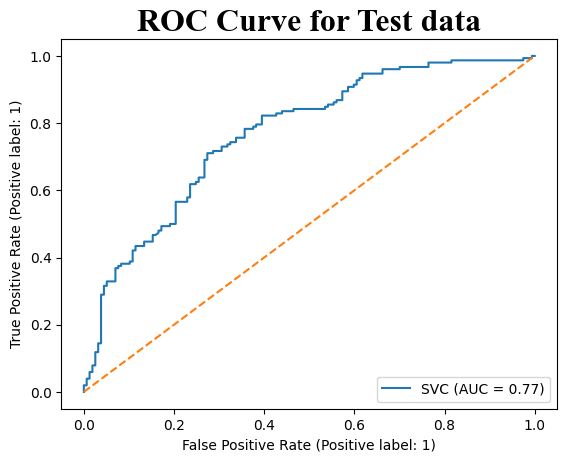

<Figure size 640x480 with 0 Axes>

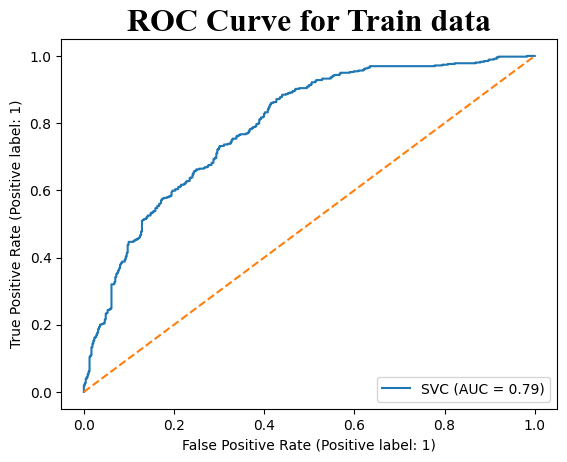

In [23]:
#ROC
roc_te = RocCurveDisplay.from_estimator(cls, x_te, y_te)
plt.clf()
roc_te.plot()
plt.plot([0, 1], ls="--")
plt.title('ROC Curve for Test data', fontsize=23, fontweight="bold", fontname="Times New Roman")

roc_tr = RocCurveDisplay.from_estimator(cls, x_tr, y_tr)
plt.clf()
roc_tr.plot()
plt.plot([0, 1], ls="--")
plt.title('ROC Curve for Train data', fontsize=23, fontweight="bold", fontname="Times New Roman")

# Learning curve

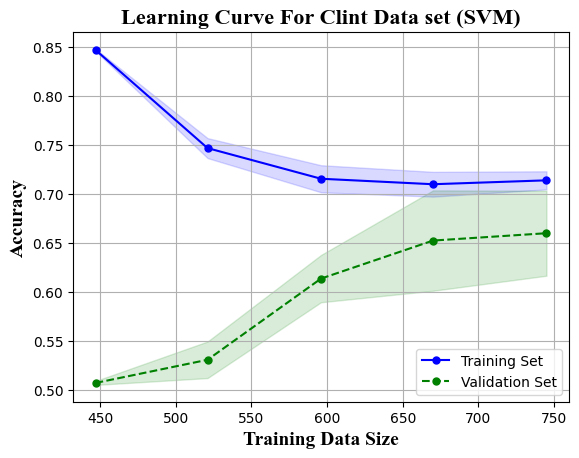

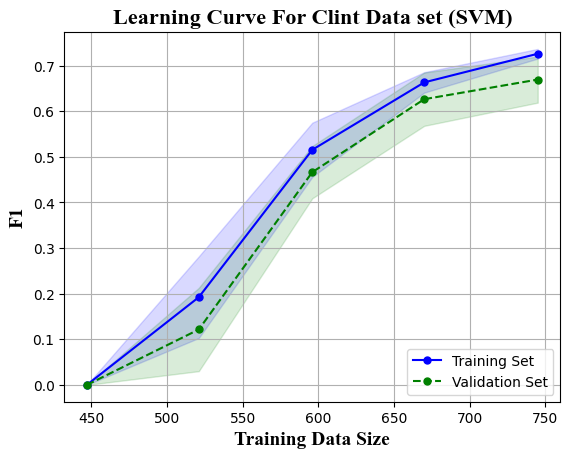

In [25]:
scores = ['accuracy', 'f1']
ylabel = ['Accuracy', 'F1']
for i,j in zip(scores, ylabel):
    train_sizes, train_score, test_score = learning_curve(cls, x_tr, y_tr, cv=5, train_sizes=np.linspace(0.1, 1.0,10),
                                                        n_jobs=1, scoring=i)
    #calculate train and test mean
    train_mean = np.mean(train_score, axis=1)
    train_std = np.std(train_score, axis=1)
    test_mean = np.mean(test_score, axis=1)
    test_std = np.std(test_score, axis=1)
    
    #graph plotting
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Set')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='o', markersize=5, linestyle='--', label='Validation Set')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve For Clint Data set (SVM)', font="Times New Roman", fontsize=16, fontweight="bold")
    plt.xlabel('Training Data Size', font="Times New Roman", fontsize=14, fontweight="bold")
    plt.ylabel(j, font="Times New Roman", fontsize=14, fontweight="bold")
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

# Validation curve

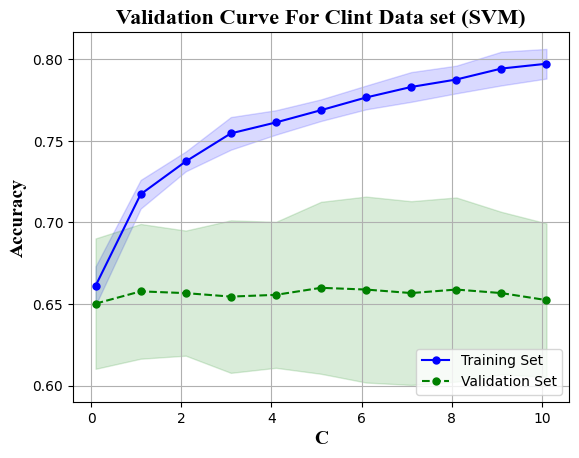

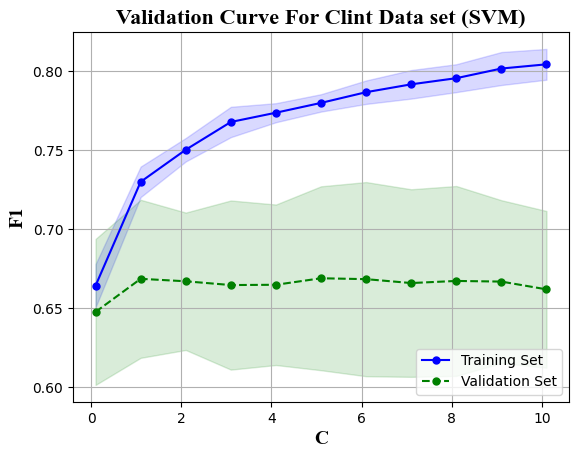

In [26]:
parameters=np.arange(0.1,11.0,1)
for i,j in zip(scores, ylabel): 
    train_sc, val_sc = validation_curve(cls, x_tr, y_tr, param_name='C', param_range=parameters, cv=5, scoring=i)
    # Calculating mean and standard deviation of training score
    mean_train_score = np.mean(train_sc, axis=1)
    std_train_score = np.std(train_sc, axis=1)
     
    # Calculating mean and standard deviation of testing score
    mean_test_score = np.mean(val_sc, axis=1)
    std_test_score = np.std(val_sc, axis=1)
    
    #graph plotting
    plt.plot(parameters, mean_train_score, color='blue', marker='o', markersize=5, label='Training Set')
    plt.fill_between(parameters, mean_train_score + std_train_score, mean_train_score - std_train_score, alpha=0.15, color='blue')
    plt.plot(parameters, mean_test_score, color='green', marker='o', markersize=5, linestyle='--', label='Validation Set')
    plt.fill_between(parameters, mean_test_score + std_test_score, mean_test_score - std_test_score, alpha=0.15, color='green')
    plt.title('Validation Curve For Clint Data set (SVM)', font="Times New Roman", fontsize=16, fontweight="bold")
    plt.xlabel('C', font="Times New Roman", fontsize=14, fontweight="bold")
    plt.ylabel(j, font="Times New Roman", fontsize=14, fontweight="bold")
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

# SHAP plot

In [ ]:
shap.initjs()
X_tr100 = shap.utils.sample(x_tr, 100)
explainer = shap.Explainer(cls.predict, X_tr100)
shap_an = explainer(x_tr)

In [ ]:
shap.summary_plot(shap_an, x_tr)

In [ ]:
shap.plots.heatmap(shap_an,  max_display=20)